<a href="https://colab.research.google.com/github/regiltcj/upwork-investx/blob/version-1/upwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Objective**
To identify the brands with growth potential from those selling on amazon so that they could be supported with sufficient credits
## **Requirement**
Create a heuristic model that can be used to rank the brands based on the growth potential that in turn indicates their credit worthiness
## **KPIs under consideration**
1. Time series
2. Periodic metrics
3. Snapshot metrics (Sellers/Brand relations)



#### Importing required libraries

In [ ]:
from glob import glob
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as sc

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Reading the dataset

In [ ]:
source_path = "/content/drive/MyDrive/upwork/dataset/"

brand_metrics_daily = pd.read_csv(source_path + "bi_brand_metrics_daily.csv")
products = pd.read_csv(source_path + "products.csv")
product_metrics_daily = pd.read_csv(source_path + "product_metrics_daily.csv")
product_offer_snapshots = pd.read_csv(source_path + "product_offer_snapshots.csv")
brand_sellers = pd.read_csv(source_path + "bi_brand_sellers.csv")
brand_segmentation = pd.read_csv(source_path + "bi_brand_segmentation.csv")

In [ ]:
brand_metrics_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664535 entries, 0 to 664534
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              664535 non-null  object 
 1   category_id        664535 non-null  int64  
 2   sample_date        664535 non-null  object 
 3   products           664535 non-null  int64  
 4   avg_sales_rank     664535 non-null  float64
 5   avg_reviews_score  580492 non-null  float64
 6   avg_reviews_count  580839 non-null  float64
 7   daily_items        664535 non-null  float64
 8   daily_items_share  664535 non-null  float64
 9   daily_sales        664535 non-null  float64
 10  daily_sales_share  664535 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 55.8+ MB


In [ ]:
print("brand_metrics_daily: {}".format(brand_metrics_daily.shape))
print("products: {}".format(products.shape))
print("product_metrics_daily: {}".format(product_metrics_daily.shape))
print("product_offer_snapshots: {}".format(product_offer_snapshots.shape))
print("brand_sellers: {}".format(brand_sellers.shape))
print("brand_segmentation: {}".format(brand_segmentation.shape))

brand_metrics_daily: (664535, 11)
products: (22922, 14)
product_metrics_daily: (1851006, 9)
product_offer_snapshots: (52264, 15)
brand_sellers: (31697, 6)
brand_segmentation: (3995, 28)


In [ ]:
# Checking the number of distinct brands from the 'products' table
print(f"Number of unique brands: {products['brand'].nunique(dropna=False)}")
print(f"Number of brands for which we have the sales data: {brand_metrics_daily['brand'].nunique(dropna=False)}")

# Creating a dataframe of all the unique brands for which we have the sales data for
brands = pd.DataFrame(products.loc[~products["brand"].isna(),"brand"])
brands.drop_duplicates(ignore_index=True, inplace=True)
brands

Number of unique brands: 4126
Number of brands for which we have the sales data: 4005


,brand
0,CLUE
1,Black N Red
2,Patriot Wholesale Direct
3,STMT
4,WE'RE NOT REALLY STRANGERS
...,...
4120,ImageMat
4121,Launch X431
4122,JIM OSBORN REPRODUCTIONS
4123,JIM OSBORN REPRODUCTIONS


i.e. We need to create a scoring mechanism the provides scores to each of the 4125 brands and could be used to find the low risk brands for investing

### ***To Do***

Time Series
- Sales and Items share
  1. Scale the total score between -1 to 1
  2. Check upon how to include weekly growth rate - Fraction of weeeks which had positive gorwth

- Review Count
  1. Try to scale the review count to a common scalre (ratio wrt catgory average) and then use it for trend analysis
  
- Pricing
  1. Need to work upon the relative pricing within a category - This would be a better option for trend analysis
  2. Scale the total score between -1 to 1
  3. Weekly growthrate similar to sales and items share


27/02

Do trend analysis on number of products/Review count and score - 3
Analyse the day on day change and how many of them are greater than 0 - 3


Complete product revenue concenteration - 12
Complete category revenue concneteration - 12 

Start with Number of sellers brand sells products exclusively

### ***Time Series***
In this list of KPIs, we analyse the trends in the time series data and each of the time serires will be translated to a score (this will be per brand per category). A weighted average (weighted based on the revenue of each category) of the above score across category will provide the score for the brand. 

---
**KPIs**
  1. Sales/share
  2. Items/share
  3. Reviews (count/score)
  4. Competition level
  5. Pricing
  6. Number of Products
---

##### **Sales share** and **Items share**
This represents the total sales revenue/number of sales(from all the different products) of a brand and category as a fraction of total sales revenue/number of sales in that particular category for a given date.
We score the brand category wise initially based on the trend and then calculate the weighted average across categories to arrive at the brand level score. <br>
**Score range:-** -1 to 1

**Discussion Points**

- Filter out those brands that does not have sufficient number of positive values rather than ust looking at the data.<br>
The 76 days can contain 0's and hnce by removing those does not have suffiient positive sales we can remove those outliers/sudden spikes at this stage itself
- From the remaining set we have to find the min_no_of_sample_dates acccordingly (from 76) -- This won't be neccessary since it would already be filered out

Have to rethink on the below point
- Half of the min_no_of_sample_dates days has to be positive

Question
 - Weight is calculated based on the daily_sales_share for both sales_share_score and items_share_score. Is this okay or should the weights be recalculated based on items_share for items_share_score -- weight accoring to item


**Preprocessing for time series analysis**

In [ ]:
# Converting the sample_date to dateimte
brand_metrics_daily.loc[:,"sample_date"] = pd.to_datetime(brand_metrics_daily["sample_date"])

In [ ]:
# Finding the number of days each of the brand-category combination has non-zero daily_sales_share
pos_sales_count = brand_metrics_daily.groupby(by=["brand", "category_id"]).apply(lambda x:sum(x["daily_sales_share"]>0)).reset_index()
pos_sales_count.rename(columns={0:"positive_sales_count"}, inplace=True)
print(f"Median number of days for which the brand-category combination has non-zero sales: {pos_sales_count['positive_sales_count'].median()}")

# tbd - To check whether the count obtained in the previous step is what expeced
# positive_sales_count.loc[positive_sales_count["positive_sales_count"]>0].sort_values(by="positive_sales_count").head(20)
# brand_metrics_daily.loc[(brand_metrics_daily["brand"].eq("Printers Jack"))&(brand_metrics_daily["category_id"].eq(21328371011)),"daily_sales_share"].value_counts()

Median number of days for which the brand-category combination has non-zero sales: 88.0


In [ ]:
# Finding the number of days for which 90% of the brands has non-zero sales
pos_sales_val_count_cum = pos_sales_count['positive_sales_count'].value_counts(normalize=True).sort_index(ascending=False).cumsum()
pos_sales_days = pos_sales_val_count_cum.loc[pos_sales_val_count_cum>0.90].index[0]
print(f"We have 90% of the brand-categories having non-zero sales for at least {pos_sales_days} days.")
print(f"Hence the analysis would be for those brand-category combinations that has non-zero sales for atleast {pos_sales_days} days")

We have 90% of the brand-categories having non-zero sales for at least 60 days.
Hence the analysis would be for those brand-category combinations that has non-zero sales for atleast 60 days


In [ ]:
# Filtering the brand-category combinations from brand_metrics_daily
# Identifying the relevant brand-category combination
pos_sales_count_filtered = pos_sales_count.loc[pos_sales_count["positive_sales_count"]>=pos_sales_days]

# Fetching the data for those brand-category combinations from brand_metrics_daily
cols = ["brand","category_id","sample_date","daily_sales_share", "daily_items_share"]
brand_metrics_daily_filtered = pd.merge(brand_metrics_daily,pos_sales_count_filtered, on=["brand","category_id"], how="inner", validate="many_to_one").loc[:,cols]

**Score calculation**

In [ ]:
# Getting the slope of all the brand-category combination

def get_growth_rate(df, field_name):
  date_oridinal = df["sample_date"].map(dt.datetime.toordinal)
  slope, intercept, r_value, p_value, std_err = sc.linregress(date_oridinal, df[field_name])
  return slope

start = dt.datetime.now()
brand_category = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"])
sales_score = brand_category.apply(get_growth_rate,"daily_sales_share").reset_index()
item_score = brand_category.apply(get_growth_rate,"daily_items_share").reset_index()
sale_item_category_score = pd.merge(sales_score,item_score, on=["brand", "category_id"], how="inner", validate="one_to_one")
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")
sale_item_category_score.rename(columns={"0_x":"sales_score" ,"0_y":"items_score"}, inplace=True)

Time taken - 15 seconds


slope - -0.004663335408395073; r_value - -0.895252587381227; p_value - 6.111051471671249e-32; std_err - 0.0002502689916154233


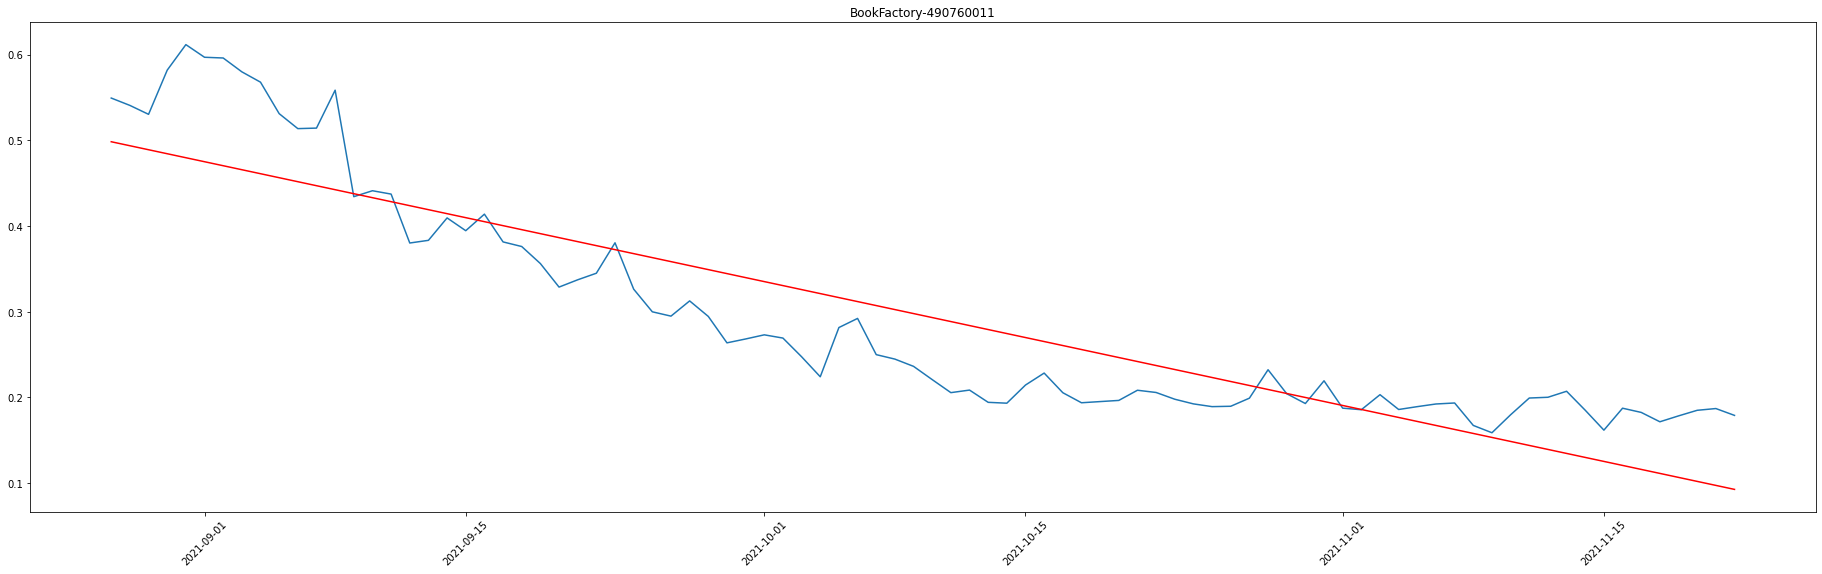

In [ ]:
# tbd
# Plotting one brand-category combination
# Get the unique brand-category combinations 
# brand_metrics_daily_filtered.loc[:,["brand","category_id"]].drop_duplicates().head(20)

plt.figure(figsize=(32,9))
brand = "BookFactory"
category_id = 490760011
# Knock Knock, 1297015011
# BookFactory, 490760011


# Fitting the linear regression for each brand-category combination and finding the slope of the trend
def get_growth_rate(x, y):
  slope, intercept, r_value, p_value, std_err = sc.linregress(x, y)
  print(f"slope - {slope}; r_value - {r_value}; p_value - {p_value}; std_err - {std_err}")
  return (slope, intercept)  

temp = brand_metrics_daily_filtered.loc[(brand_metrics_daily_filtered["brand"].eq(brand))&(brand_metrics_daily_filtered["category_id"].eq(category_id)),["sample_date" ,"daily_sales_share"]]
date_oridinal = temp["sample_date"].map(dt.datetime.toordinal)
slope, intercept = get_growth_rate(date_oridinal, temp["daily_sales_share"])
temp["predicted"] = intercept + slope*date_oridinal
temp.index = temp["sample_date"]
plt.title(f"{brand}-{category_id}")
plt.plot(temp["daily_sales_share"])
plt.plot(temp["predicted"], 'r', label='fitted line')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Computing the weightage for each category to arrive at the final score for the brand
# Category with more sales is given higher weightage. (Weight is calculated based on the daily_sales_share)

category_weights = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"])["daily_sales_share"].sum().reset_index()
category_weights.loc[:,"weightage"] = category_weights.groupby(by=["brand"])["daily_sales_share"].transform(lambda x:x/x.sum())
category_weights.drop(columns=["daily_sales_share"],inplace=True)

In [ ]:
# Calcualting the total score of each brand as weighted sum of individual score across each category
weighted_sales_item_score = pd.merge(category_weights, sale_item_category_score, on=["brand", "category_id"], how="inner")
weighted_sales_item_score["weighted_sales_score"] = weighted_sales_item_score["sales_score"]*weighted_sales_item_score["weightage"]
weighted_sales_item_score["weighted_items_score"] = weighted_sales_item_score["sales_score"]*weighted_sales_item_score["weightage"]
weighted_sales_item_score = weighted_sales_item_score.groupby(by="brand").sum().loc[:, ["weighted_sales_score","weighted_items_score"]].reset_index()
weighted_sales_item_score

,brand,weighted_sales_score,weighted_items_score
0,Cambridge,4.829810e-07,4.829810e-07
1,"""N/A""",-2.055785e-06,-2.055785e-06
2,"""NA""",4.078274e-07,4.078274e-07
3,''N/A'',-1.231572e-06,-1.231572e-06
4,(RED),-5.264679e-05,-5.264679e-05
...,...,...,...
3579,zeonkit,8.102830e-08,8.102830e-08
3580,§ONAO\大直,2.232355e-06,2.232355e-06
3581,✅ REGISTERROLL,-1.078679e-06,-1.078679e-06
3582,✅ RegisterRoll,2.609492e-05,2.609492e-05


In [ ]:
brands = pd.merge(brands, weighted_sales_item_score, on="brand", how="left")
brands

,brand,weighted_sales_score,weighted_items_score
0,CLUE,-3.107092e-06,-3.107092e-06
1,Black N Red,7.413071e-07,7.413071e-07
2,Patriot Wholesale Direct,NaN,NaN
3,STMT,6.778559e-04,6.778559e-04
4,WE'RE NOT REALLY STRANGERS,NaN,NaN
...,...,...,...
4120,ImageMat,-1.979611e-07,-1.979611e-07
4121,Launch X431,5.146155e-07,5.146155e-07
4122,JIM OSBORN REPRODUCTIONS,3.064845e-07,3.064845e-07
4123,JIM OSBORN REPRODUCTIONS,-7.022184e-07,-7.022184e-07


##### **Reviews (count/score)** and **Number of Products**
Need to analyse if there is any actual change in these values for each brand-category combination and then how to quantify it 

##### **Reviews Count**

**Discussion Points**

Question
- Used the joined table of product_metrics_daily and products instead of brand_metrics_daily since it would be better to analyse the reviews at a product level and the then aggregate it for brands
- There is -1 value for the reviews_count. This has been replaced as nan
- I think we will have to scale the reviews_count rather than using absolute reviews_count
- Or will it be a better option to derive new feature of daily change in review score and use that for trend analysis to get a better score. (In that case will have to think about how to handle if the initial day is having a 0 review_score)
- Weights are calculated based on the ratio of total sales of the product to the total sales of the brand. Is that okay or will that cause bias toward those products that were available for larger duration

**Preprocessing for time series analysis**

In [ ]:
# Joining product_metrics_daily to products to obtain the brand information for each product
# Note: category_id in product_metrics_daily is same as main_sales_rank_category_id in products
product_brand_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")
product_brand_daily["reviews_count"].replace(-1, np.nan, inplace=True)

In [ ]:
pos_reviews_count = product_brand_daily.groupby(by="product_id").apply(lambda x:sum(~x["reviews_count"].isna())).reset_index()
pos_reviews_count.rename(columns={0:"pos_reviews_count"}, inplace=True)
print(f"Median number of days for which the product has non-negative reviews count: {pos_reviews_count['pos_reviews_count'].median()}")

pos_reviews_count_cum = pos_reviews_count["pos_reviews_count"].value_counts(normalize=True).sort_index(ascending=False).cumsum()
pos_reviews_count_days = pos_reviews_count_cum.loc[pos_reviews_count_cum>0.9].index[0]
print(f"We have 90% of the products that has non-negative reviews count for at least {pos_reviews_count_days} days.")
print(f"Hence the analysis would be for those products that has non-negative reviews count for atleast {pos_reviews_count_days} days")

Median number of days for which the product has non-negative reviews count: 88.0
We have 90% of the products that has non-negative reviews count for at least 0 days.
Hence the analysis would be for those products that has non-negative reviews count for atleast 0 days


In [ ]:
# Meaning of 0 days in the above result - We have around 20% products that has 0 non-zero reviews_count. Hence removing such products
# Filtering the products from product_brand_daily
# Identifying the relevant brand-category combination
pos_reviews_count_filtered = pos_reviews_count.loc[pos_reviews_count["pos_reviews_count"]>pos_reviews_count_days]

# Fetching the data for those brand-category combinations from brand_metrics_daily
cols = ["product_id","category_id","brand","reviews_count","sample_date", "daily_sales"]
product_brand_daily_filtered = pd.merge(product_brand_daily,pos_reviews_count_filtered, on=["product_id"], how="inner", validate="many_to_one").loc[:,cols]

In [ ]:
# Finding the median reviews_count of the product across the timeframe
median_product_reviews_count = product_brand_daily_filtered.groupby(by=["product_id"])["reviews_count"].median()
# Imputing the missing reviews_count with the median value of reviews_count for each product (This is done only if reviews_count is not null atleast once for the product) 
product_brand_daily_filtered.loc[product_brand_daily_filtered["reviews_count"].isna(),"reviews_count"] = product_brand_daily_filtered.loc[product_brand_daily_filtered["reviews_count"].isna(),:].apply(lambda x:median_product_reviews_count[x["product_id"]],axis=1)

In [ ]:
# Converting the sample_date to datetime
product_brand_daily_filtered.loc[:,"sample_date"] = pd.to_datetime(product_brand_daily_filtered["sample_date"])

**Score calculation**

In [ ]:
# Getting the slope of all the brand-product combination

def get_growth_rate(df, field_name):
  date_oridinal = df["sample_date"].map(dt.datetime.toordinal)
  slope, intercept, r_value, p_value, std_err = sc.linregress(date_oridinal, df[field_name])
  return slope

start = dt.datetime.now()
product_reviews_count_score = product_brand_daily_filtered.groupby(by=["product_id","brand"]).apply(get_growth_rate,"reviews_count").reset_index()
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")
product_reviews_count_score.rename(columns={0:"reviews_count_score"}, inplace=True)

Time taken - 18 seconds


slope - 137.72259768353828; r_value - 0.7977408265024966; p_value - 1.368070100136447e-20; std_err - 11.2256582352194


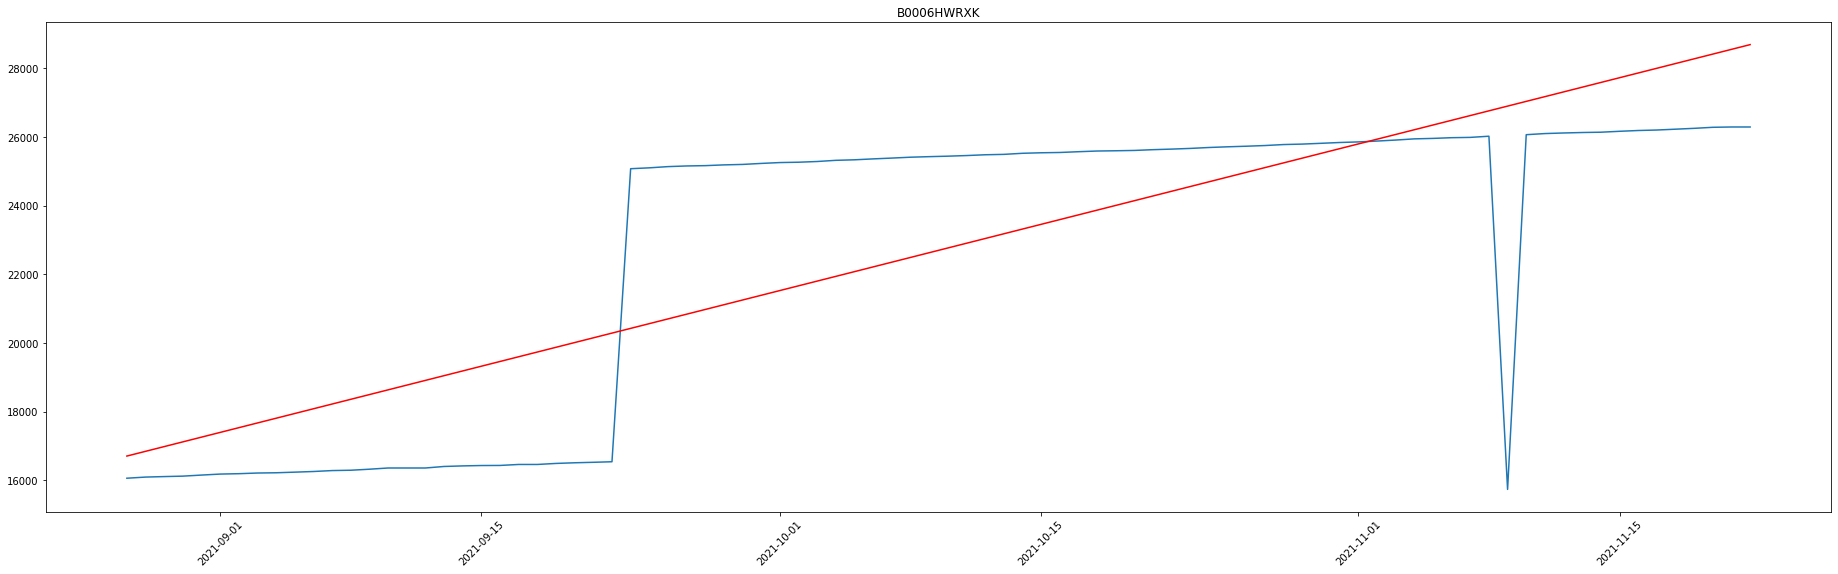

In [ ]:
# tbd
# Plotting one product
# Get the unique product
# brand_metrics_daily_filtered.loc[:,["brand","category_id"]].drop_duplicates().head(20)

plt.figure(figsize=(32,9))
product_id = "B0006HWRXK"
# B094JZQX76
# B07CHHSTT9
# B00O80WCKO

# Fitting the linear regression for each brand-category combination and finding the slope of the trend
def get_growth_rate(x, y):
  slope, intercept, r_value, p_value, std_err = sc.linregress(x, y)
  print(f"slope - {slope}; r_value - {r_value}; p_value - {p_value}; std_err - {std_err}")
  return (slope, intercept)  

temp = product_brand_daily_filtered.loc[(product_brand_daily_filtered["product_id"].eq(product_id)),["sample_date" ,"reviews_count"]]
date_oridinal = temp["sample_date"].map(dt.datetime.toordinal)
slope, intercept = get_growth_rate(date_oridinal, temp["reviews_count"])
temp["predicted"] = intercept + slope*date_oridinal
temp.index = temp["sample_date"]
plt.title(f"{product_id}")
plt.plot(temp["reviews_count"])
plt.plot(temp["predicted"], 'r', label='fitted line')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Computing the weightage for each category to arrive at the final score for the brand
# Category with more sales is given higher weightage. (Weight is calculated based on the daily_sales_share)

product_weights = product_brand_daily_filtered.groupby(by=["brand", "product_id"])["daily_sales"].sum().reset_index()
product_weights.loc[:,"weightage"] = product_weights.groupby(by=["brand"])["daily_sales"].transform(lambda x:x/x.sum())
product_weights.drop(columns=["daily_sales"],inplace=True)

In [ ]:
# Calcualting the total score of each brand as weighted sum of individual score across each category
weighted_reviews_count_score = pd.merge(product_weights, product_reviews_count_score, on=["brand", "product_id"], how="inner")
weighted_reviews_count_score["weighted_reviews_count_score"] = weighted_reviews_count_score["reviews_count_score"]*weighted_reviews_count_score["weightage"]
weighted_reviews_count_score = weighted_reviews_count_score.groupby(by="brand").sum().loc[:, "weighted_reviews_count_score"].reset_index()
weighted_reviews_count_score

,brand,weighted_reviews_count_score
0,Cambridge,0.016167
1,"""N/A""",0.064115
2,"""NA""",0.011976
3,''N/A'',0.039656
4,100 GREETINGS,3.710805
...,...,...
3416,§ONAO\大直,0.130418
3417,✅ REGISTERROLL,0.027456
3418,✅ RegisterRoll,0.201733
3419,コクヨ(KOKUYO),0.065302


In [ ]:
brands = pd.merge(brands, weighted_reviews_count_score, on="brand", how="left")
brands

,brand,weighted_sales_score,weighted_items_score,weighted_reviews_count_score
0,CLUE,-3.107092e-06,-3.107092e-06,0.218133
1,Black N Red,7.413071e-07,7.413071e-07,0.000000
2,Patriot Wholesale Direct,NaN,NaN,0.089254
3,STMT,6.778559e-04,6.778559e-04,-16.680056
4,WE'RE NOT REALLY STRANGERS,NaN,NaN,5.731618
...,...,...,...,...
4120,ImageMat,-1.979611e-07,-1.979611e-07,0.023088
4121,Launch X431,5.146155e-07,5.146155e-07,0.035645
4122,JIM OSBORN REPRODUCTIONS,3.064845e-07,3.064845e-07,NaN
4123,JIM OSBORN REPRODUCTIONS,-7.022184e-07,-7.022184e-07,NaN


##### **Reviews Score**

**Discussion Points**

Question
- Does negative vaule indicate missing value. Here the reviews_score is not replaced with nan since negative reviews are possible. Is that fine
- I feel it is better to derive new feature of daily change in review score and use that for trend analysis to get a better score. (In that case will have to think about how to handle if the initial day is having a 0 review_score)

**Preprocessing for time series analysis**

In [ ]:
# Joining product_metrics_daily to products to obtain the brand information for each product
# Note: category_id in product_metrics_daily is same as main_sales_rank_category_id in products
product_brand_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")

In [ ]:
non_null_review_score = product_brand_daily.groupby(by="product_id").apply(lambda x:sum(~x["reviews_score"].isna())).reset_index()
non_null_review_score.rename(columns={0:"non_null_reviews_score"}, inplace=True)
print(f"Median number of days for which the product has non-null reviews score: {non_null_review_score['non_null_reviews_score'].median()}")

non_null_reviews_score_cum = non_null_review_score["non_null_reviews_score"].value_counts(normalize=True).sort_index(ascending=False).cumsum()
non_null_reviews_score_days = non_null_reviews_score_cum.loc[non_null_reviews_score_cum>0.9].index[0]
print(f"We have 90% of the products that has non-null reviews score for at least {non_null_reviews_score_days} days.")
print(f"Hence the analysis would be for those products that has non-null reviews score for atleast {non_null_reviews_score_days} days")

Median number of days for which the product has non-null reviews score: 88.0
We have 90% of the products that has non-null reviews score for at least 0 days.
Hence the analysis would be for those products that has non-null reviews score for atleast 0 days


In [ ]:
# Meaning of 0 days in the above result - We have around 20% products that has 0 non-zero reviews_count. Hence removing such products
# Filtering the products from product_brand_daily
# Identifying the relevant brand-category combination
non_null_review_score_filtered = non_null_review_score.loc[non_null_review_score["non_null_reviews_score"]>non_null_reviews_score_days]

# Fetching the data for those brand-category combinations from brand_metrics_daily
cols = ["product_id","category_id","brand","reviews_score","sample_date", "daily_sales"]
product_brand_daily_filtered = pd.merge(product_brand_daily,non_null_review_score_filtered, on=["product_id"], how="inner", validate="many_to_one").loc[:,cols]

In [ ]:
# Finding the median reviews_score of the product across the timeframe
median_product_reviews_score = product_brand_daily_filtered.groupby(by=["product_id"])["reviews_score"].median()
# Imputing the missing reviews_score with the median value of reviews_score for each product (This is done only if reviews_score is not null atleast once for the product) 
product_brand_daily_filtered.loc[product_brand_daily_filtered["reviews_score"].isna(),"reviews_score"] = product_brand_daily_filtered.loc[product_brand_daily_filtered["reviews_score"].isna(),:].apply(lambda x:median_product_reviews_score[x["product_id"]],axis=1)

In [ ]:
# Converting the sample_date to datetime
product_brand_daily_filtered.loc[:,"sample_date"] = pd.to_datetime(product_brand_daily_filtered["sample_date"])

**Score calculation**

In [ ]:
# Getting the slope of all the brand-product combination

def get_growth_rate(df, field_name):
  date_oridinal = df["sample_date"].map(dt.datetime.toordinal)
  slope, intercept, r_value, p_value, std_err = sc.linregress(date_oridinal, df[field_name])
  return slope

start = dt.datetime.now()
product_reviews_score_score = product_brand_daily_filtered.groupby(by=["product_id","brand"]).apply(get_growth_rate,"reviews_score").reset_index()
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")
product_reviews_score_score.rename(columns={0:"reviews_score_score"}, inplace=True)

Time taken - 18 seconds


In [ ]:
# tbd
# product_brand_daily_filtered.loc[product_brand_daily_filtered["product_id"]=="B003X4TFN8",:]
# median_product_reviews_score["B003X4TFN8"]
# product_brand_daily.loc[product_brand_daily["product_id"]=="B003X4TFN8",["reviews_score"]].value_counts(dropna=False)
# non_null_reviews_score_days

In [ ]:
product_reviews_score_score.sort_values(by="reviews_score_score").head(12000).tail(10)

,product_id,brand,reviews_score_score
7655,B072QWMSTX,Topdrawer,0.0
6511,B01JMHMFGI,CURRENT,0.0
7683,B0735V9JQS,CroninCards,0.0
7682,B07357TMTT,Magic Whiteboard Products,0.0
6456,B01INETMUI,Basicos MR,0.0
7681,B0734PHBZJ,PIXILUV,0.0
6459,B01IQ5WI3M,Discovery,0.0
6460,B01IQ7LC8W,"TOPS Business Forms, Inc",0.0
6461,B01IQF09QA,TOP7572,0.0
6454,B01IIAWFD8,Five Star,0.0


slope - 0.0; r_value - 0.0; p_value - 1.0; std_err - 0.0


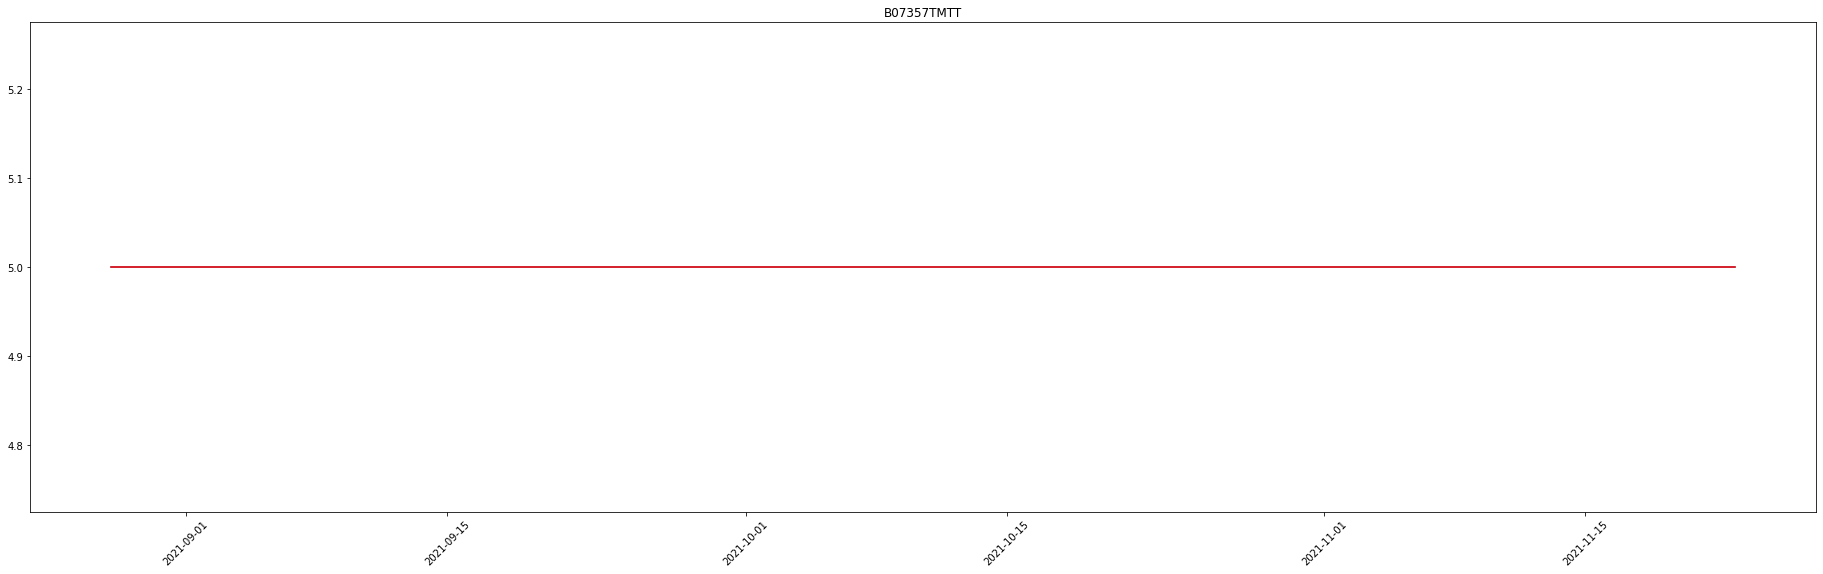

In [ ]:
# tbd
# Plotting one product
# Get the unique product
# brand_metrics_daily_filtered.loc[:,["brand","category_id"]].drop_duplicates().head(20)

plt.figure(figsize=(32,9))
product_id = "B07357TMTT"
# B09K5NBV6Z
# B09K5QVDFP

# Fitting the linear regression for each brand-category combination and finding the slope of the trend
def get_growth_rate(x, y):
  slope, intercept, r_value, p_value, std_err = sc.linregress(x, y)
  print(f"slope - {slope}; r_value - {r_value}; p_value - {p_value}; std_err - {std_err}")
  return (slope, intercept)  

temp = product_brand_daily_filtered.loc[(product_brand_daily_filtered["product_id"].eq(product_id)),["sample_date" ,"reviews_score"]]
date_oridinal = temp["sample_date"].map(dt.datetime.toordinal)
slope, intercept = get_growth_rate(date_oridinal, temp["reviews_score"])
temp["predicted"] = intercept + slope*date_oridinal
temp.index = temp["sample_date"]
plt.title(f"{product_id}")
plt.plot(temp["reviews_score"])
plt.plot(temp["predicted"], 'r', label='fitted line')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Computing the weightage for each category to arrive at the final score for the brand
# Category with more sales is given higher weightage. (Weight is calculated based on the daily_sales_share)

product_weights = product_brand_daily_filtered.groupby(by=["brand", "product_id"])["daily_sales"].sum().reset_index()
product_weights.loc[:,"weightage"] = product_weights.groupby(by=["brand"])["daily_sales"].transform(lambda x:x/x.sum())
product_weights.drop(columns=["daily_sales"],inplace=True)

In [ ]:
# Calcualting the total score of each brand as weighted sum of individual score across each category
weighted_reviews_score = pd.merge(product_weights, product_reviews_count_score, on=["brand", "product_id"], how="inner")
weighted_reviews_score["weighted_reviews_score"] = weighted_reviews_score["reviews_count_score"]*weighted_reviews_score["weightage"]
weighted_reviews_score = weighted_reviews_score.groupby(by="brand").sum().loc[:, "weighted_reviews_score"].reset_index()
weighted_reviews_score

,brand,weighted_reviews_score
0,Cambridge,0.016167
1,"""N/A""",0.064115
2,"""NA""",0.011976
3,''N/A'',0.039656
4,100 GREETINGS,3.710805
...,...,...
3416,§ONAO\大直,0.130418
3417,✅ REGISTERROLL,0.027456
3418,✅ RegisterRoll,0.201733
3419,コクヨ(KOKUYO),0.065302


In [ ]:
brands = pd.merge(brands, weighted_reviews_score, on="brand", how="left")
brands

,brand,weighted_sales_score,weighted_items_score,weighted_reviews_count_score,weighted_reviews_score
0,CLUE,-3.107092e-06,-3.107092e-06,0.218133,0.218133
1,Black N Red,7.413071e-07,7.413071e-07,0.000000,0.000000
2,Patriot Wholesale Direct,NaN,NaN,0.089254,0.089254
3,STMT,6.778559e-04,6.778559e-04,-16.680056,-16.680056
4,WE'RE NOT REALLY STRANGERS,NaN,NaN,5.731618,5.731618
...,...,...,...,...,...
4120,ImageMat,-1.979611e-07,-1.979611e-07,0.023088,0.023088
4121,Launch X431,5.146155e-07,5.146155e-07,0.035645,0.035645
4122,JIM OSBORN REPRODUCTIONS,3.064845e-07,3.064845e-07,NaN,NaN
4123,JIM OSBORN REPRODUCTIONS,-7.022184e-07,-7.022184e-07,NaN,NaN


##### **Pricing**

**Discussion Points**
- Time series analysis needs to be done at product level and the aggregate it for the brand level

Question
- We have -1 as new_price for few brands. It has been replaced as null indicating it is a missing value and has not been included in the calculation of the mean
- We have only 7 unique category_id in product_metrics daily while in brand_metrics_daily we have 43. So should we merge brand_metrics_daily to obtain the category_id or can we go ahead with category_id in product_metrics_daily
- Currently the weights are calculated them based on the share of total sales of a brand. Is that okay?
- I feel it is better to use relative scoring since the slope is unscaled and might cause issues

**Preprocessing for time series analysis**

In [ ]:
# Joining product_metrics_daily to products to obtain the brand information for each product
# Note: category_id in product_metrics_daily is same as main_sales_rank_category_id in products
product_brand_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")
product_brand_daily.replace(-1, np.nan, inplace=True)

In [ ]:
not_null_price_count = product_brand_daily.groupby(by="product_id").apply(lambda x:sum(~x["new_price"].isna())).reset_index()
not_null_price_count.rename(columns={0:"not_null_price_count"}, inplace=True)
print(f"Median number of days for which the product has not null price: {not_null_price_count['not_null_price_count'].median()}")

not_null_price_count_cum = not_null_price_count["not_null_price_count"].value_counts(normalize=True).sort_index(ascending=False).cumsum()
not_null_price_days = not_null_price_count_cum.loc[not_null_price_count_cum>0.90].index[0]
print(f"We have 90% of the products having non-null price for at least {not_null_price_days} days.")
print(f"Hence the analysis would be for those products that has non-null price for atleast {not_null_price_days} days")

Median number of days for which the product has not null price: 88.0
We have 90% of the products having non-null price for at least 63 days.
Hence the analysis would be for those products that has non-null price for atleast 63 days


In [ ]:
# Filtering the products from product_brand_daily
# Identifying the relevant brand-category combination
not_null_price_count_filtered = not_null_price_count.loc[not_null_price_count["not_null_price_count"]>=not_null_price_days]

# Fetching the data for those brand-category combinations from brand_metrics_daily
cols = ["product_id","category_id","brand","new_price","sample_date", "daily_sales"]
product_brand_daily_filtered = pd.merge(product_brand_daily,not_null_price_count_filtered, on=["product_id"], how="inner", validate="many_to_one").loc[:,cols]

In [ ]:
# Finding the median price of the product across the timeframe
median_product_price = product_brand_daily_filtered.groupby(by=["product_id"])["new_price"].median()
# Imputing the missing new_price with the median value of new_price for each product (This is done only if new_price is not null atleast once for the product) 
product_brand_daily_filtered.loc[product_brand_daily_filtered["new_price"].isna(),"new_price"] = product_brand_daily_filtered.loc[product_brand_daily_filtered["new_price"].isna(),:].apply(lambda x:median_product_price[x["product_id"]],axis=1)

In [ ]:
# Converting the sample_date to datetime
product_brand_daily_filtered.loc[:,"sample_date"] = pd.to_datetime(product_brand_daily_filtered["sample_date"])

**Score calculation**

In [ ]:
# Getting the slope of all the brand-category combination

def get_growth_rate(df, field_name):
  date_oridinal = df["sample_date"].map(dt.datetime.toordinal)
  slope, intercept, r_value, p_value, std_err = sc.linregress(date_oridinal, df[field_name])
  return slope

start = dt.datetime.now()
price_product_score = product_brand_daily_filtered.groupby(by=["product_id","brand"]).apply(get_growth_rate,"new_price").reset_index()
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")
price_product_score.rename(columns={0:"pricing_score"}, inplace=True)

Time taken - 21 seconds


slope - 1.97323095347117; r_value - 0.6337979408261022; p_value - 3.4035372119464394e-11; std_err - 0.25967936064136793


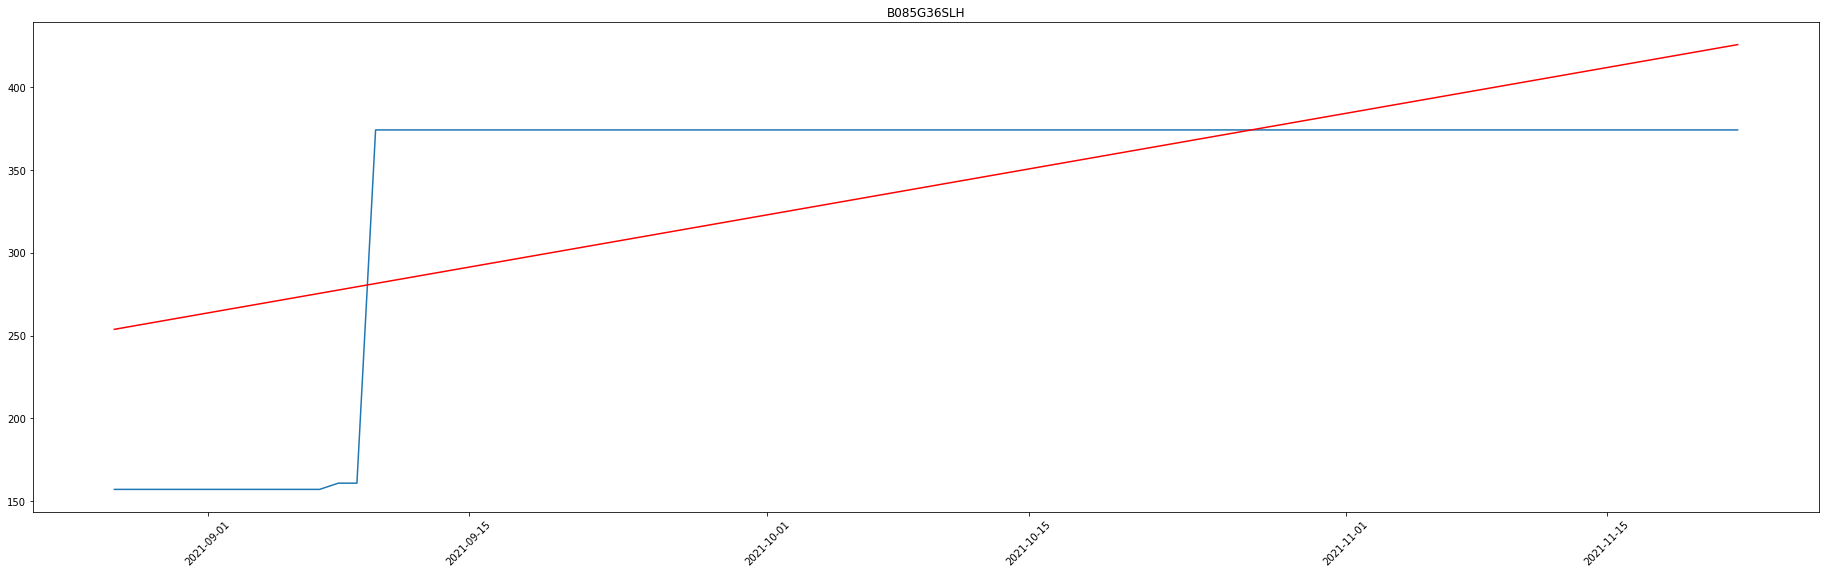

In [ ]:
# tbd
# Plotting one brand-category combination
# Get the unique brand-category combinations 
# brand_metrics_daily_filtered.loc[:,["brand","category_id"]].drop_duplicates().head(20)

plt.figure(figsize=(32,9))
product_id = "B085G36SLH"
# B00CIH94M8

# Fitting the linear regression for each brand-category combination and finding the slope of the trend
def get_growth_rate(x, y):
  slope, intercept, r_value, p_value, std_err = sc.linregress(x, y)
  print(f"slope - {slope}; r_value - {r_value}; p_value - {p_value}; std_err - {std_err}")
  return (slope, intercept)  

temp = product_brand_daily_filtered.loc[(product_brand_daily_filtered["product_id"].eq(product_id)),["sample_date" ,"new_price"]]
date_oridinal = temp["sample_date"].map(dt.datetime.toordinal)
slope, intercept = get_growth_rate(date_oridinal, temp["new_price"])
temp["predicted"] = intercept + slope*date_oridinal
temp.index = temp["sample_date"]
plt.title(f"{product_id}")
plt.plot(temp["new_price"])
plt.plot(temp["predicted"], 'r', label='fitted line')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Computing the weightage for each category to arrive at the final score for the brand
# Category with more sales is given higher weightage. (Weight is calculated based on the daily_sales_share)

product_weights = product_brand_daily_filtered.groupby(by=["brand", "product_id"])["daily_sales"].sum().reset_index()
product_weights.loc[:,"weightage"] = product_weights.groupby(by=["brand"])["daily_sales"].transform(lambda x:x/x.sum())
product_weights.drop(columns=["daily_sales"],inplace=True)

In [ ]:
# Calcualting the total score of each brand as weighted sum of individual score across each category
weighted_pricing_score = pd.merge(product_weights, price_product_score, on=["brand", "product_id"], how="inner")
weighted_pricing_score["weighted_pricing_score"] = weighted_pricing_score["pricing_score"]*weighted_pricing_score["weightage"]
weighted_pricing_score = weighted_pricing_score.groupby(by="brand").sum().loc[:, "weighted_pricing_score"].reset_index()
weighted_pricing_score

,brand,weighted_pricing_score
0,Cambridge,-0.095261
1,"""N/A""",0.006071
2,"""NA""",-0.001140
3,''N/A'',0.052844
4,(RED),-1.292239
...,...,...
3638,§ONAO\大直,0.000000
3639,✅ REGISTERROLL,0.006629
3640,✅ RegisterRoll,0.040769
3641,モレスキン(Moleskine),-0.005616


In [ ]:
brands = pd.merge(brands, weighted_pricing_score, on="brand", how="left")
brands

,brand,weighted_sales_score,weighted_items_score,weighted_reviews_count_score,weighted_reviews_score,weighted_pricing_score
0,CLUE,-3.107092e-06,-3.107092e-06,0.218133,0.218133,-0.019115
1,Black N Red,7.413071e-07,7.413071e-07,0.000000,0.000000,-0.012504
2,Patriot Wholesale Direct,NaN,NaN,0.089254,0.089254,-0.013790
3,STMT,6.778559e-04,6.778559e-04,-16.680056,-16.680056,-0.004263
4,WE'RE NOT REALLY STRANGERS,NaN,NaN,5.731618,5.731618,NaN
...,...,...,...,...,...,...
4120,ImageMat,-1.979611e-07,-1.979611e-07,0.023088,0.023088,0.090227
4121,Launch X431,5.146155e-07,5.146155e-07,0.035645,0.035645,0.000000
4122,JIM OSBORN REPRODUCTIONS,3.064845e-07,3.064845e-07,NaN,NaN,0.000000
4123,JIM OSBORN REPRODUCTIONS,-7.022184e-07,-7.022184e-07,NaN,NaN,-0.011448


In [ ]:
# Another approach to identify the products that has null value for new_price for the entire time frame

# # Computing the number of records with new_price as null to the total number of records
# def ratio_of_null_count(df):
#   return df["new_price"].isna().sum()/df.shape[0]

# # Computing the ratio of days for which the new_price is null to the total number of days for which we have data for for that sample_id
# null_price_ratio = product_brand_daily.groupby(by="product_id").apply(ratio_of_null_count)
# # Identifying the products which has new_price as null for all the available sample_date
# null_price_products = null_price_ratio[null_price_ratio==1]

# # Removing the above products from the analysis
# product_brand_daily = product_brand_daily.loc[~product_brand_daily["product_id"].isin(null_price_products.index),:]

**Scoring on relative pricing**

Ratio of median price of the brand in a category to the median price in that category

In [ ]:
# Joining product_metrics_daily to products to obtain the brand information for each product
# Note: category_id in product_metrics_daily is same as main_sales_rank_category_id in products
product_brand_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")
product_brand_daily["new_price"].replace(-1, np.nan, inplace=True)

In [ ]:
# Finding the average price of each of the product across the time frame
product_average_price = product_brand_daily.groupby(by=["product_id", "brand", "category_id"])["new_price"].sum().reset_index()
# There are few products with average new_price as 0. This might be because data not available for any of the date. 
# Removing such products from the analysis
product_average_price = product_average_price.loc[product_average_price["new_price"]!=0,:]

In [ ]:
# Finding the median price of products in each category
category_median_price = product_average_price.groupby(by=["category_id"]).median().reset_index()
# Finding the median price of products of each brand in a particular category
brand_category_median_price = product_average_price.groupby(by=["brand", "category_id"])["new_price"].median().reset_index()

# Calculating the score of brand-category combination as a ratio of the price of the median brand in a category to the median price of the category
brand_category_price = pd.merge(brand_category_median_price, category_median_price, on="category_id", how="left", validate="many_to_one", suffixes=(None, "_category"))
brand_category_price["price_ratio"] = brand_category_price["new_price"]/brand_category_price["new_price_category"]
brand_category_price

,brand,category_id,new_price,new_price_category,price_ratio
0,Cambridge,1064954,2877.233318,1274.149981,2.258159
1,"""N/A""",1064954,1417.599972,1274.149981,1.112585
2,"""NA""",1064954,1319.219966,1274.149981,1.035373
3,''N/A'',1064954,1010.719983,1274.149981,0.793250
4,(RED),1064954,14690.406784,1274.149981,11.529574
...,...,...,...,...,...
4005,✅ REGISTERROLL,1064954,5270.820007,1274.149981,4.136734
4006,✅ RegisterRoll,1064954,8983.400024,1274.149981,7.050504
4007,コクヨ(KOKUYO),1064954,1075.250000,1274.149981,0.843896
4008,モレスキン(Moleskine),1064954,649.777492,1274.149981,0.509969


##### **Competition level** - Average metrics
Number of other brands that sell products in the same category. This has to be calculated at day level.
> High level tasks
 - Data will have to be sourced by combining products and bi_product_metrics_daily.
 - For each brand identify the products sold on a given date and corresponding categories. Find the brands that sold products from the same category on the same date
 - That would provide us the number of brands that sells products in the same category as a given brand and category for a given date
 - Compute the average competition count for a timeframe

### ***Periodic***
In this list of KPIs, we analyse the period as a whole and come up with an aggregate value for each of the brand for the whole time frame.

---
**KPIs**
  1. Competition (see Shay’s calculations about entropy, ratio to leader/s, amazon selling, pricing levels)
  2. Out of stock rates
  3. Product revenue concentration
  4. Category revenue concentration
---
**Tasks**
 - General
   1. Identify the tables required to gather the information

 - Specfic to metric
   1. Brainstorm on how to quantify the revenue distribution across product/category
---


##### Competition (see Shay’s calculations about entropy, ratio to leader/s, amazon selling, pricing levels)

##### **Out of stock rates**

**Discussion Points**

- Use out_of_stock_pct to calculate the score instead of out_of_stck_pct_90
- Consider only positive values since -1 indicates missing value (Value not obtianed from API)

Question
- Mean out_of_stock_pct is calculated. Is that okay or should we go ahead with median?


In [ ]:
# out_of_stock for the whole time frame.
# There are null values in the joined table, but it is removed while calculating the mean out_of_stock_pct
out_of_stocks = pd.merge(product_snapshots, products, on="product_id", how="inner", validate="one_to_one").loc[:,["product_id", "brand","out_of_stock_pct"]]

# Replacing -1 with NaN as -1 indicate mmissing value
out_of_stocks["out_of_stock_pct"].replace( -1, np.nan, inplace=True)

# Missing values in out_of_stock_pct is ignored while computing the mean. Also the null values in brand is also ignored
out_of_stock_score = out_of_stocks.groupby(by="brand")["out_of_stock_pct"].mean().reset_index()

# Rescaling so that 0% out_of_stock_pct has highest score and 100% out_of_stock_pct has lowest score
out_of_stock_score["out_of_stock_score"] = out_of_stock_score["out_of_stock_pct"].map(lambda x:(100-x)/100)
out_of_stock_score

,brand,out_of_stock_pct,out_of_stock_score
0,Cambridge,0.0,1.000
1,"""N/A""",0.0,1.000
2,"""NA""",0.0,1.000
3,''N/A'',0.0,1.000
4,(RED),2.0,0.980
...,...,...,...
4120,✅ REGISTERROLL,0.0,1.000
4121,✅ RegisterRoll,7.7,0.923
4122,コクヨ(KOKUYO),22.5,0.775
4123,モレスキン(Moleskine),0.0,1.000


In [ ]:
out_of_stock_score.drop(columns=["out_of_stock_pct"], inplace=True)
brands = pd.merge(brands, out_of_stock_score, on="brand", how="left")
brands

,brand,weighted_sales_score,weighted_items_score,weighted_reviews_count_score,weighted_reviews_score,weighted_pricing_score,out_of_stock_score
0,CLUE,-3.107092e-06,-3.107092e-06,0.218133,0.218133,-0.019115,1.00
1,Black N Red,7.413071e-07,7.413071e-07,0.000000,0.000000,-0.012504,1.00
2,Patriot Wholesale Direct,NaN,NaN,0.089254,0.089254,-0.013790,1.00
3,STMT,6.778559e-04,6.778559e-04,-16.680056,-16.680056,-0.004263,1.00
4,WE'RE NOT REALLY STRANGERS,NaN,NaN,5.731618,5.731618,NaN,0.80
...,...,...,...,...,...,...,...
4120,ImageMat,-1.979611e-07,-1.979611e-07,0.023088,0.023088,0.090227,0.91
4121,Launch X431,5.146155e-07,5.146155e-07,0.035645,0.035645,0.000000,1.00
4122,JIM OSBORN REPRODUCTIONS,3.064845e-07,3.064845e-07,NaN,NaN,0.000000,1.00
4123,JIM OSBORN REPRODUCTIONS,-7.022184e-07,-7.022184e-07,NaN,NaN,-0.011448,1.00


##### **Product revenue concentration**
Measure how the total revenue of the brand is distributed across its products. This consists of two parts - 
 - Number of products each brand has
 - How the revenue is distributed across the products

**Discussion Points**

- Use total sales of the brands across products and then use that to check how it is distributed for calculating product_revenue_concenteration
- Arrive at the final score by multiplying product concenteration and product revenue concenteration
- Check for discrepancy if any in using the product_metrics_daily and brand_metrics_daily 

  - brand 1 - 10 product (average of products across total time frame)
  - brand 2 - 1 product (average of products across total time frame)
  - brand 3 - 5 product (average of products across total time frame)
  - median of 10,1,5 to get the 
  - then to get the score we dvide by median
  - brand 1 - 10/16
  - brand 2 - 1/16'

Question
- If we are using total sales of the each products across the time frame and then the distribution of sales of brand across the products, will that cause bias towards those products that sold through out the sample_date. Few products are sold only few days while few products are sold for the whole time frame
- Entropy calculated for product_revenue_distribution has been rescaled to 0 to 1 (0 indicating the total revenue of the brand across timeframe is concenterated in few product while 1 indicating the revenue is more or less uniformly distributed). Is this ok?


**Product concenteration metric**

In [ ]:
# Here we find the mean number of products across the time frame for each brand and represent it as a fraction of the median of mean number of products 
brand_product_conc = (brand_metrics_daily.groupby(by="brand")["products"].mean()/brand_metrics_daily.groupby(by="brand")["products"].mean().median()).reset_index()
brand_product_conc.rename(columns={"products":"product_conc"},inplace=True)

 **Product revenue concenteration metric**

In [ ]:
# Entropy is used to measure how uniformly the total revenue of the brand is distributed across its different products
# Entropy is lowest if the distribution is uniform while it is maximum if it s concenterated on few datapoints
# Drawback of entropy - If a brand has just one product it will have the lowest entropy (since it is always uniformly distributed)

brand_products = product_brand_daily.groupby(by=["brand", "product_id"])["daily_sales"].sum().reset_index()

# Function to calculate entropy
# We assign maximum entropy if the total sales of a brand (across all the brands) is 0 or if the brand has only one brand
calculate_entropy = lambda x:sc.entropy(x["daily_sales"]/x["daily_sales"].sum()) if x["daily_sales"].sum()!=0 and len(x["daily_sales"])>1 else 1000

# Calculating entropy for each brand based on daily_sales
brand_product_revenue_entropy = brand_products.groupby(by="brand").apply(calculate_entropy).reset_index()
brand_product_revenue_entropy.rename(columns={0:"product_revenue_entropy"}, inplace=True)

In [ ]:
# Finding the brand with maximum entropy (other than 1000)
max_entropy = brand_product_revenue_entropy.loc[brand_product_revenue_entropy["product_revenue_entropy"]!=1000, "product_revenue_entropy"].max()
# Replacing the entropy of 1000 with the second maximum value
brand_product_revenue_entropy["product_revenue_entropy"].replace(1000, max_entropy, inplace=True)

# Rescaling the entropy so that uniform distribution has highest score and concenterated distribution has lowest score
scaler = MinMaxScaler()
brand_product_revenue_entropy["product_revenue_conc"] = scaler.fit_transform(brand_product_revenue_entropy[["product_revenue_entropy"]])
brand_product_revenue_entropy["product_revenue_conc"] = brand_product_revenue_entropy["product_revenue_conc"].map(lambda x:1-x)
brand_product_revenue_entropy.drop(columns=["product_revenue_entropy"], inplace=True)

In [ ]:
brand_product_revenue_conc_score = pd.merge(brand_product_revenue_entropy, brand_product_conc, on="brand", how="inner", validate="one_to_one")
brand_product_revenue_conc_score["product_revenue_conc_score"] = brand_product_revenue_conc_score["product_conc"]*brand_product_revenue_conc_score["product_revenue_conc"]
brand_product_revenue_conc_score

,brand,product_revenue_conc,product_conc,product_revenue_conc_score
0,Cambridge,1.110223e-16,1.000000,1.110223e-16
1,"""N/A""",7.911450e-01,1.416327,1.120520e+00
2,"""NA""",1.110223e-16,1.000000,1.110223e-16
3,''N/A'',1.110223e-16,1.000000,1.110223e-16
4,(RED),1.110223e-16,1.000000,1.110223e-16
...,...,...,...,...
4000,✅ REGISTERROLL,1.110223e-16,1.000000,1.110223e-16
4001,✅ RegisterRoll,8.621839e-01,7.363636,6.348809e+00
4002,コクヨ(KOKUYO),8.689369e-01,1.000000,8.689369e-01
4003,モレスキン(Moleskine),7.292019e-01,2.666667,1.944539e+00


In [ ]:
brand_product_revenue_conc_score.drop(columns=["product_conc", "product_revenue_conc"], inplace=True)
brands = pd.merge(brands, brand_product_revenue_conc_score, on="brand", how="left")
brands

,brand,weighted_sales_score,weighted_items_score,weighted_reviews_count_score,weighted_reviews_score,weighted_pricing_score,out_of_stock_score,product_revenue_conc_score
0,CLUE,-3.107092e-06,-3.107092e-06,0.218133,0.218133,-0.019115,1.00,1.110223e-16
1,Black N Red,7.413071e-07,7.413071e-07,0.000000,0.000000,-0.012504,1.00,1.110223e-16
2,Patriot Wholesale Direct,NaN,NaN,0.089254,0.089254,-0.013790,1.00,1.110223e-16
3,STMT,6.778559e-04,6.778559e-04,-16.680056,-16.680056,-0.004263,1.00,2.376472e+00
4,WE'RE NOT REALLY STRANGERS,NaN,NaN,5.731618,5.731618,NaN,0.80,1.110223e-16
...,...,...,...,...,...,...,...,...
4120,ImageMat,-1.979611e-07,-1.979611e-07,0.023088,0.023088,0.090227,0.91,1.110223e-16
4121,Launch X431,5.146155e-07,5.146155e-07,0.035645,0.035645,0.000000,1.00,1.110223e-16
4122,JIM OSBORN REPRODUCTIONS,3.064845e-07,3.064845e-07,NaN,NaN,0.000000,1.00,1.110223e-16
4123,JIM OSBORN REPRODUCTIONS,-7.022184e-07,-7.022184e-07,NaN,NaN,-0.011448,1.00,1.110223e-16


##### **Category revenue concentration**

**Discussion Points**

- Use total sales of the brands across products and then use that to check how it is distributed for calculating product_revenue_concenteration
- Arrive at the final score by multiplying product concenteration and product revenue concenteration
- Check for discrepancy if any in using the product_metrics_daily and brand_metrics_daily 


Question
- If we are using total sales of the each products across the time frame and then the distribution of sales of brand across the products, will that cause bias towards those products that sold through out the sample_date. Few products are sold only few days while few products are sold for the whole time frame
- Entropy calculated for product_revenue_distribution has been rescaled to 0 to 1 (0 indicating the total revenue of the brand across timeframe is concenterated in few product while 1 indicating the revenue is more or less uniformly distributed). Is this ok?


**Category concenteration metric**

In [ ]:
# Here we find the mean number of categories across the time frame for each brand and represent it as a fraction of the median of mean number of categories 
brand_category = brand_metrics_daily.groupby(by=["brand"]).nunique().reset_index()
brand_category.rename(columns={"category_id":"category_count"}, inplace=True)
brand_category_conc = (brand_category.groupby(by="brand")["category_count"].mean()/brand_category.groupby(by="brand")["category_count"].mean().median()).reset_index()
brand_category_conc.rename(columns={"category_count":"category_conc"},inplace=True)

 **Category revenue concenteration metric**

In [ ]:
brand_category_sales = brand_metrics_daily.groupby(by=["brand", "category_id"])["daily_sales_share"].sum().reset_index()

# Function to calculate entropy
# We assign maximum entropy if the total sales of a brand (across all the brands) is 0 or if the brand has only one brand
calculate_entropy = lambda x:sc.entropy(x["daily_sales_share"]/x["daily_sales_share"].sum()) if x["daily_sales_share"].sum()!=0 and len(x["daily_sales_share"])>1 else 1000

# Calculating entropy for each brand based on daily_sales
brand_category_revenue_entropy = brand_category_sales.groupby(by="brand").apply(calculate_entropy).reset_index()
brand_category_revenue_entropy.rename(columns={0:"category_revenue_entropy"}, inplace=True)

In [ ]:
# Finding the brand with maximum entropy (other than 1000)
max_entropy = brand_category_revenue_entropy.loc[brand_category_revenue_entropy["category_revenue_entropy"]!=1000, "category_revenue_entropy"].max()
# Replacing the entropy of 1000 with the second maximum value
brand_category_revenue_entropy["category_revenue_entropy"].replace(1000, max_entropy, inplace=True)

# Rescaling the entropy so that uniform distribution has highest score and concenterated distribution has lowest score
scaler = MinMaxScaler()
brand_category_revenue_entropy["category_revenue_conc"] = scaler.fit_transform(brand_category_revenue_entropy[["category_revenue_entropy"]])
brand_category_revenue_entropy["category_revenue_conc"] = brand_category_revenue_entropy["category_revenue_conc"].map(lambda x:1-x)
brand_category_revenue_entropy.drop(columns=["category_revenue_entropy"], inplace=True)

In [ ]:
brand_category_revenue_conc_score = pd.merge(brand_category_revenue_entropy, brand_category_conc, on="brand", how="inner", validate="one_to_one")
brand_category_revenue_conc_score["category_revenue_conc_score"] = brand_category_revenue_conc_score["category_conc"]*brand_category_revenue_conc_score["category_revenue_conc"]
brand_category_revenue_conc_score

,brand,category_revenue_conc,category_conc,category_revenue_conc_score
0,Cambridge,0.000000,1.0,0.000000
1,"""N/A""",0.686128,3.0,2.058384
2,"""NA""",0.846034,2.0,1.692069
3,''N/A'',0.000000,1.0,0.000000
4,(RED),0.000000,1.0,0.000000
...,...,...,...,...
4000,✅ REGISTERROLL,0.000000,1.0,0.000000
4001,✅ RegisterRoll,0.718763,2.0,1.437526
4002,コクヨ(KOKUYO),0.720856,2.0,1.441712
4003,モレスキン(Moleskine),0.651747,3.0,1.955242


In [ ]:
brand_category_revenue_conc_score.drop(columns=["category_conc", "category_revenue_conc"], inplace=True)
brands = pd.merge(brands, brand_category_revenue_conc_score, on="brand", how="left")
brands

,brand,weighted_sales_score,weighted_items_score,weighted_reviews_count_score,weighted_reviews_score,weighted_pricing_score,out_of_stock_score,product_revenue_conc_score,category_revenue_conc_score
0,CLUE,-3.107092e-06,-3.107092e-06,0.218133,0.218133,-0.019115,1.00,1.110223e-16,0.000000
1,Black N Red,7.413071e-07,7.413071e-07,0.000000,0.000000,-0.012504,1.00,1.110223e-16,0.000000
2,Patriot Wholesale Direct,NaN,NaN,0.089254,0.089254,-0.013790,1.00,1.110223e-16,0.000000
3,STMT,6.778559e-04,6.778559e-04,-16.680056,-16.680056,-0.004263,1.00,2.376472e+00,2.042832
4,WE'RE NOT REALLY STRANGERS,NaN,NaN,5.731618,5.731618,NaN,0.80,1.110223e-16,1.828637
...,...,...,...,...,...,...,...,...,...
4120,ImageMat,-1.979611e-07,-1.979611e-07,0.023088,0.023088,0.090227,0.91,1.110223e-16,0.000000
4121,Launch X431,5.146155e-07,5.146155e-07,0.035645,0.035645,0.000000,1.00,1.110223e-16,1.436703
4122,JIM OSBORN REPRODUCTIONS,3.064845e-07,3.064845e-07,NaN,NaN,0.000000,1.00,1.110223e-16,0.000000
4123,JIM OSBORN REPRODUCTIONS,-7.022184e-07,-7.022184e-07,NaN,NaN,-0.011448,1.00,1.110223e-16,0.000000


### ***Snapshot***
In this list of KPIs, we analyse the data at a given point of time and come up with score that can be used to compare the brands.

---
**KPIs**
  1. Number of Sellers
  2. Brand sells its products not/exclusively
  3. Seller reviews (count/score)
  4. Product reviews
  5. Pricing
---
**Tasks**
 - General
   1. TODO

 - Specfic to metric
   1. TODO
---

##### **Number of Sellers**
Number of Sellers -bell curve, need to think where the optimum resides, probably depending on the product’s volume. Maybe we should look at the avg #sellers per product.


In the brand_segmentation, we have brand and the correspondng sellers. But we do not have the product level info so will have to join some other dataset to get the average sellers per product
We will have to combine product_offer_snapshots and products table to get both seller and product information

In [ ]:
product_sellers = pd.merge(product_offer_snapshots, products, on="product_id", how="inner", validate="many_to_one")
product_sellers = product_sellers.loc[:,["product_id", "brand", "seller_id"]]
product_sellers

,product_id,brand,seller_id
0,B07TCDJ3SD,Disney autograph book,A75QK3A71TS
1,B07TCDJ3SD,Disney autograph book,A1YDYOELZV7I7L
2,B07TCDJ3SD,Disney autograph book,A2S6PE851L0H3Q
3,B07TCDJ3SD,Disney autograph book,A3TLCXPZ76GUTH
4,B07TCDJ3SD,Disney autograph book,A75QK3A71TS
...,...,...,...
52259,B09DNZ3SCF,MiCa Direct,A3VX2A818YU2WE
52260,B09255QTTX,DOZZZ,A3W3MK6WH01VP1
52261,B08GL1NJD5,Ampersand,A05735203IHNYLYOV7H15
52262,B095WVF4L9,le vent,A08809411W1AC3U3JH5BP


##### Brand sells its products not/exclusively

##### Seller reviews (count/score)

##### Product reviews

##### Pricing

**Discussion Points**

Question
- Have calculated the price range (max_price - min_price) on the field recent_price after combining the datasets product_offer_snapshots and products)
- Now to aggregate it to brand level, should we be using the same weightage of total sales share that we used for pricing, reviews_count and reviews_score


In [ ]:
product_sellers = pd.merge(product_offer_snapshots, products, on="product_id", how="inner", validate="many_to_one")
product_sellers

In [ ]:
get_price_range = lambda x:x["recent_price"].max()-x["recent_price"].min()
# Ratio of product; eight accoring to product-daily_ale
product_sellers.groupby(by=["product_id", "brand"]).apply(get_price_range).reset_index()

,product_id,brand,0
0,0030522048,Brand: Harcourt Brace College Publishers,1872.33
1,0062273205,HarperBusiness,22.90
2,0380784300,Harpercollins,9.98
3,0394800761,Random House Books for Young Readers,23.80
4,0439732255,Scholastic,857.57
...,...,...,...
8797,B09M26VFTX,RAK TRACK,0.00
8798,B09M46FBQS,Desmond,0.00
8799,B09M6C4ZTZ,BuyRegisterRolls,0.00
8800,B09M7RZCDB,4COU,0.00


In [ ]:
Relook at the daily change in review count and review score

Pricing - Time series analysis needs to be done at product level and the aggregate it for the brand level

brand 1 - 10 product (average of products across total time frame)
brand 2 - 1 product (average of products across total time frame)
brand 3 - 5 product (average of products across total time frame)

median of 10,1,5 to get the 
then to get the score we didvide by median

brand 1 - 10/16
brand 2 - 1/16

In [ ]:
Num of Products score	Sales shares of products score	Total score(addition)	Total score (multiplication)
0.571428571	0.5	1.071428571	0.285714286
1.142857143	1	2.142857143	1.142857143
0.571428571	1	1.571428571	0.571428571
1.142857143	0.5	1.642857143	0.571428571